<a href="https://www.kaggle.com/code/lilychebotarova/wids-2024-datathon?scriptVersionId=190062970" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview
[WIDS Datathon 2024 Challenge 1](https://www.kaggle.com/competitions/widsdatathon2024-challenge1) focused on developing a model to predict timeliness of metastatic cancer diagnosis for patients. 

## The Dataset:
Provided by Gilead Sciences this real-world dataset contains information about demographics, diagnosis and treatment options, and insurance provided about patients who were diagnosed with breast cancer from 2015-2018.It was enriched with third party geo-demographic data to provide views into the socio economic aspects that may contribute to health equity. For this challenge, the dataset was then further enriched with zip code level toxicology data NASA/Columbia University.

## Objective
The primary goal is to detect relationships between demographics of the patient with the likelihood of getting timely treatment by building a model to predict if the patients received metastatic cancer diagnosis within 90 days of screening. 

## Work performed
The analysis and model development involve several steps, including data preprocessing, exploratory data analysis, feature engineering, and model training with hyperparameter tuning. The models used include Random Forest and XGBoost classifiers, with hyperparameter tuning to optimize performance.

## Summary Results



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
train_df = pd.read_csv('/kaggle/input/widsdatathon2024-challenge1/training.csv')
test_df = pd.read_csv('/kaggle/input/widsdatathon2024-challenge1/test.csv')

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12906 entries, 0 to 12905
Data columns (total 83 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             12906 non-null  int64  
 1   patient_race                           6521 non-null   object 
 2   payer_type                             11103 non-null  object 
 3   patient_state                          12855 non-null  object 
 4   patient_zip3                           12906 non-null  int64  
 5   patient_age                            12906 non-null  int64  
 6   patient_gender                         12906 non-null  object 
 7   bmi                                    3941 non-null   float64
 8   breast_cancer_diagnosis_code           12906 non-null  object 
 9   breast_cancer_diagnosis_desc           12906 non-null  object 
 10  metastatic_cancer_diagnosis_code       12906 non-null  object 
 11  me

# Data Preprocessing

In [5]:
# drop columns 
train_df_cleaned = train_df.drop(columns=['metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 
                                          'patient_gender', 'breast_cancer_diagnosis_desc', 'Ozone', 'PM25', 'N02'])

#fill missing race values with 'Unknown'
train_df_cleaned.fillna({'patient_race':'Unknown'}, inplace=True)

#impute PM25, Ozone and N02
#train_df_cleaned.fillna({'PM25': train_df_cleaned['PM25'].median()}, inplace=True)

# Drop other NAs
columns_except_bmi_race = train_df_cleaned.columns.difference(['bmi', 'patient_race'])
train_df_cleaned.dropna(subset=columns_except_bmi_race, inplace=True)

train_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11065 entries, 0 to 12905
Data columns (total 76 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   patient_id                        11065 non-null  int64  
 1   patient_race                      11065 non-null  object 
 2   payer_type                        11065 non-null  object 
 3   patient_state                     11065 non-null  object 
 4   patient_zip3                      11065 non-null  int64  
 5   patient_age                       11065 non-null  int64  
 6   bmi                               3408 non-null   float64
 7   breast_cancer_diagnosis_code      11065 non-null  object 
 8   metastatic_cancer_diagnosis_code  11065 non-null  object 
 9   Region                            11065 non-null  object 
 10  Division                          11065 non-null  object 
 11  population                        11065 non-null  float64
 12  density  

In [6]:
# Checking for duplicates 
train_df_cleaned.duplicated().sum()

0

In [7]:
# Statistical Summary
train_df_cleaned.describe()

,patient_id,patient_zip3,patient_age,bmi,population,density,age_median,age_under_10,age_10_to_19,age_20s,...,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,DiagPeriodL90D
count,11065.000000,11065.000000,11065.000000,3408.000000,11065.000000,11065.000000,11065.000000,11065.000000,11065.000000,11065.000000,...,11065.000000,11065.000000,11065.000000,11065.000000,11065.000000,11065.000000,11065.000000,11065.000000,11065.000000,11065.000000
mean,548062.099864,570.256033,59.535924,28.966693,20689.194147,1580.890924,40.523162,11.140358,12.964062,13.240612,...,5.604721,6.586227,18.190825,13.360838,13.420636,4.433483,27.997268,8.615483,7.071604,0.611387
std,260475.687170,273.422351,13.262390,5.615150,13919.589093,2995.712542,4.012982,1.488561,1.889971,3.230837,...,6.203611,3.531380,16.902306,3.701379,5.210638,4.808442,5.129322,4.235939,3.061074,0.487457
min,100063.000000,101.000000,18.000000,14.000000,635.545455,0.916667,28.875000,5.218519,6.314286,5.925000,...,0.002564,0.433333,0.194444,6.010000,3.433333,0.000000,12.460784,2.440000,1.200000,0.000000
25%,322422.000000,333.000000,51.000000,24.730000,9322.887097,169.840580,37.157143,10.160656,11.772414,11.002000,...,1.303448,3.892593,4.677083,10.327273,9.863514,0.969355,24.866667,5.604762,4.929688,0.000000
50%,545801.000000,553.000000,59.000000,28.150000,19132.212120,700.337500,40.640909,11.039216,12.940625,12.531667,...,3.510811,5.658065,11.895833,12.930769,12.180952,2.747222,27.788235,7.465714,6.847059,1.000000
75%,773415.000000,837.000000,67.000000,32.920000,29859.758620,1666.515385,42.896364,12.194118,14.030303,14.971053,...,7.848214,8.850769,27.594872,15.609302,16.644444,5.958824,30.709375,10.787500,8.600000,1.000000
max,999896.000000,998.000000,91.000000,75.000000,71374.131580,21172.000000,54.570000,17.675000,29.575000,36.900000,...,33.188889,26.429870,91.005085,35.155556,38.347826,26.755000,48.020000,27.566102,25.200000,1.000000


In [8]:
#Preprocessing tets data the same way
test_df_cleaned = test_df.drop(columns=['metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type', 
                                        'patient_gender', 'breast_cancer_diagnosis_desc','Ozone', 'PM25', 'N02'])

test_df_cleaned.fillna({'patient_race':'Unknown'}, inplace=True)
test_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5792 entries, 0 to 5791
Data columns (total 75 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   patient_id                        5792 non-null   int64  
 1   patient_race                      5792 non-null   object 
 2   payer_type                        5032 non-null   object 
 3   patient_state                     5771 non-null   object 
 4   patient_zip3                      5792 non-null   int64  
 5   patient_age                       5792 non-null   int64  
 6   bmi                               1777 non-null   float64
 7   breast_cancer_diagnosis_code      5792 non-null   object 
 8   metastatic_cancer_diagnosis_code  5792 non-null   object 
 9   Region                            5771 non-null   object 
 10  Division                          5771 non-null   object 
 11  population                        5792 non-null   float64
 12  densit

# Exploratory Data Analysis

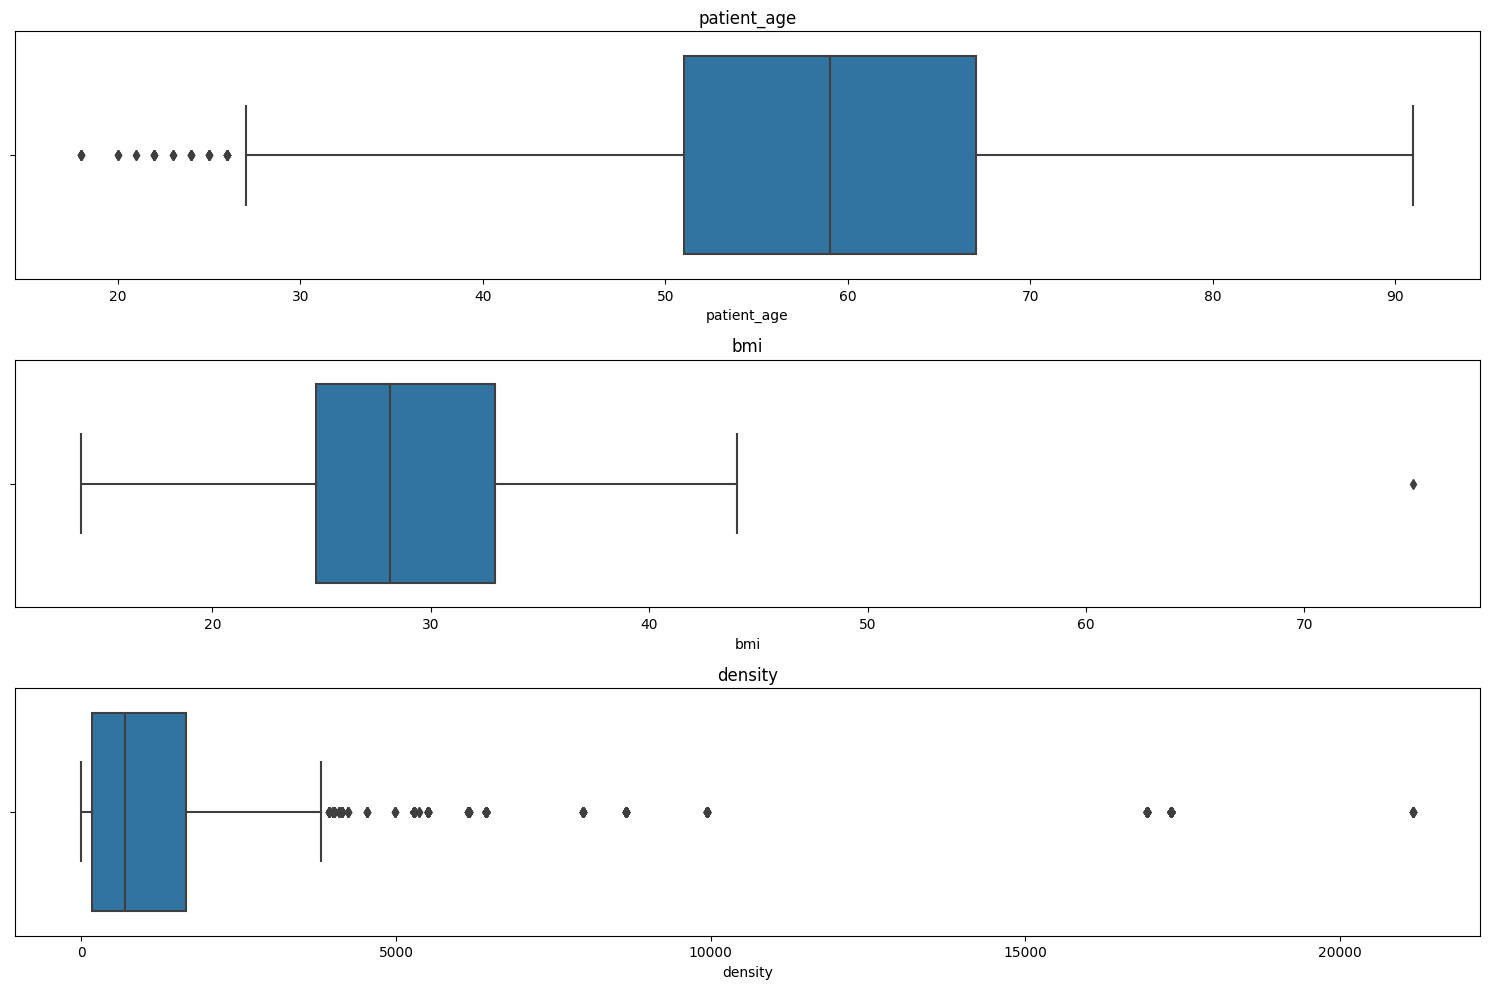

In [9]:
#Numerical Variables
key_numerical_vars = ['patient_age', 'bmi', 'density']

plt.figure(figsize=(15, 10))
for i, col in enumerate(key_numerical_vars):
    plt.subplot(len(key_numerical_vars), 1, i + 1)
    sns.boxplot(x=train_df_cleaned[col])
    plt.title(col)
plt.tight_layout()
plt.show()



#### Key Numerical Variables:
Patient Age (patient_age): The distribution seems typical for a clinical dataset with a wide range of ages. There don't appear to be extreme outliers.

BMI (bmi): There are outliers, especially on the higher side. Remember, -1 was used as a placeholder for missing values.

Density (density): This variable shows a range of values with several outliers indicating areas of extremely high population density.

Ozone (Ozone), PM2.5 (PM25), and Nitrogen Dioxide (N02): These environmental factors show some outliers, which could indicate areas with particularly high or low levels of these pollutants.

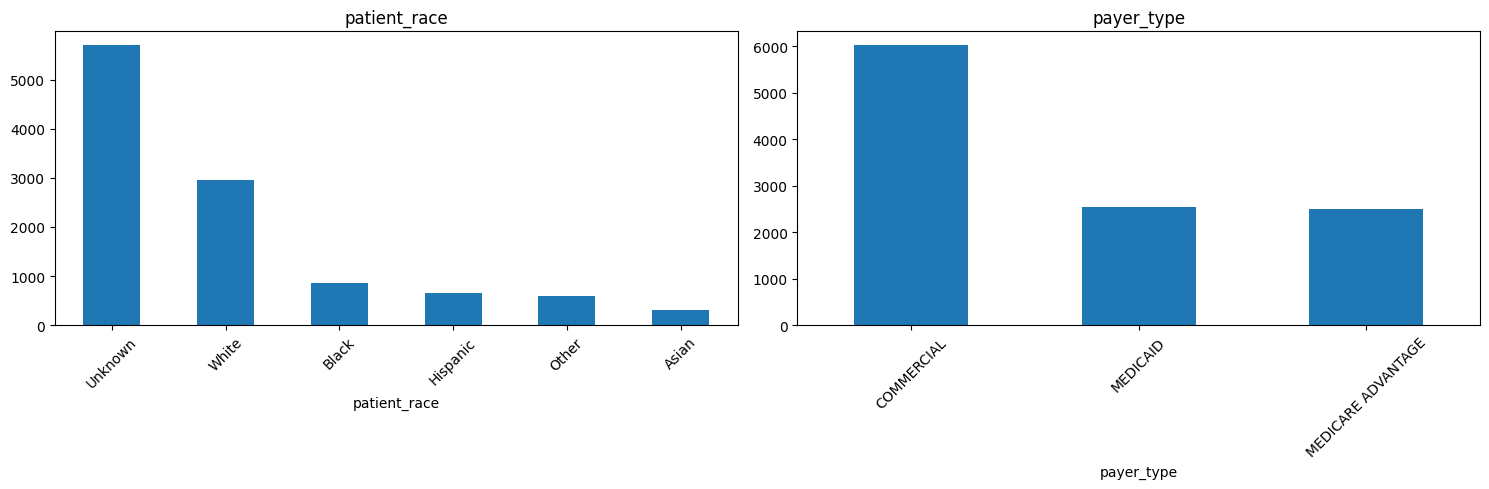

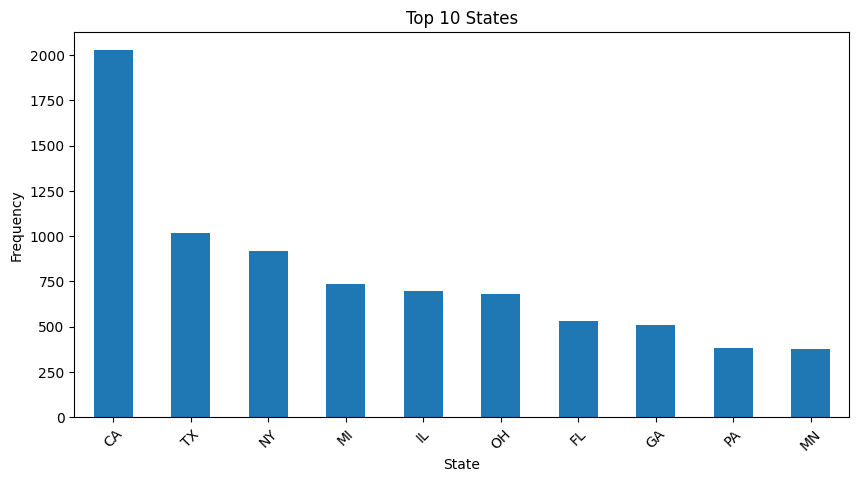

In [10]:
# Categorical Variables

# Plot for Patient Race and Payer Type
plt.figure(figsize=(15, 5))
for i, col in enumerate(['patient_race', 'payer_type']):
    plt.subplot(1, 2, i + 1)
    train_df_cleaned[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Displaying the top 10 states in terms of frequency
top_states = train_df_cleaned['patient_state'].value_counts().head(10)
plt.figure(figsize=(10, 5))
top_states.plot(kind='bar')
plt.title('Top 10 States')
plt.xlabel('State')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()




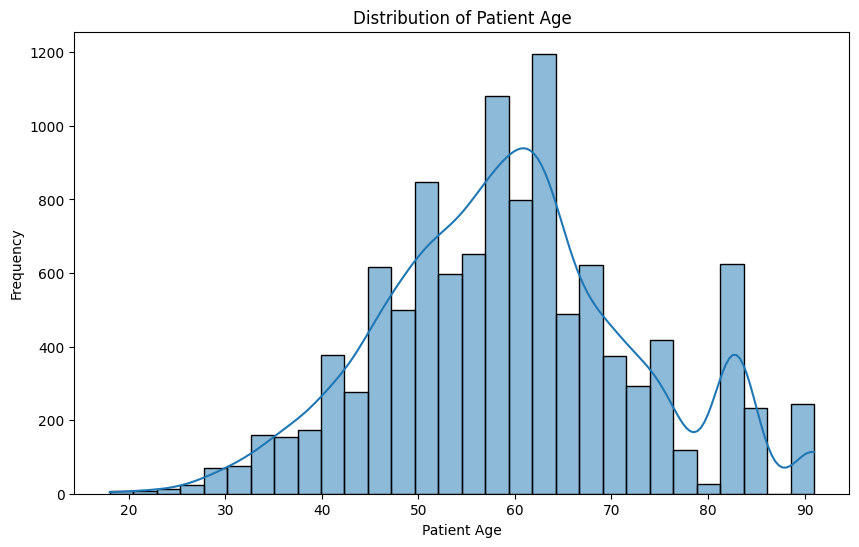

count    11065.000000
mean        59.535924
std         13.262390
min         18.000000
1%          30.000000
5%          38.000000
10%         43.000000
25%         51.000000
50%         59.000000
max         91.000000
Name: patient_age, dtype: float64

In [11]:
# Analyzing the patient_age distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df_cleaned['patient_age'], bins=30, kde=True)
plt.title('Distribution of Patient Age')
plt.xlabel('Patient Age')
plt.ylabel('Frequency')
plt.show()

# Descriptive statistics focusing on the lower percentiles
age_lower_percentiles = train_df_cleaned['patient_age'].describe(percentiles=[.01, .05, .10, .25])
age_lower_percentiles


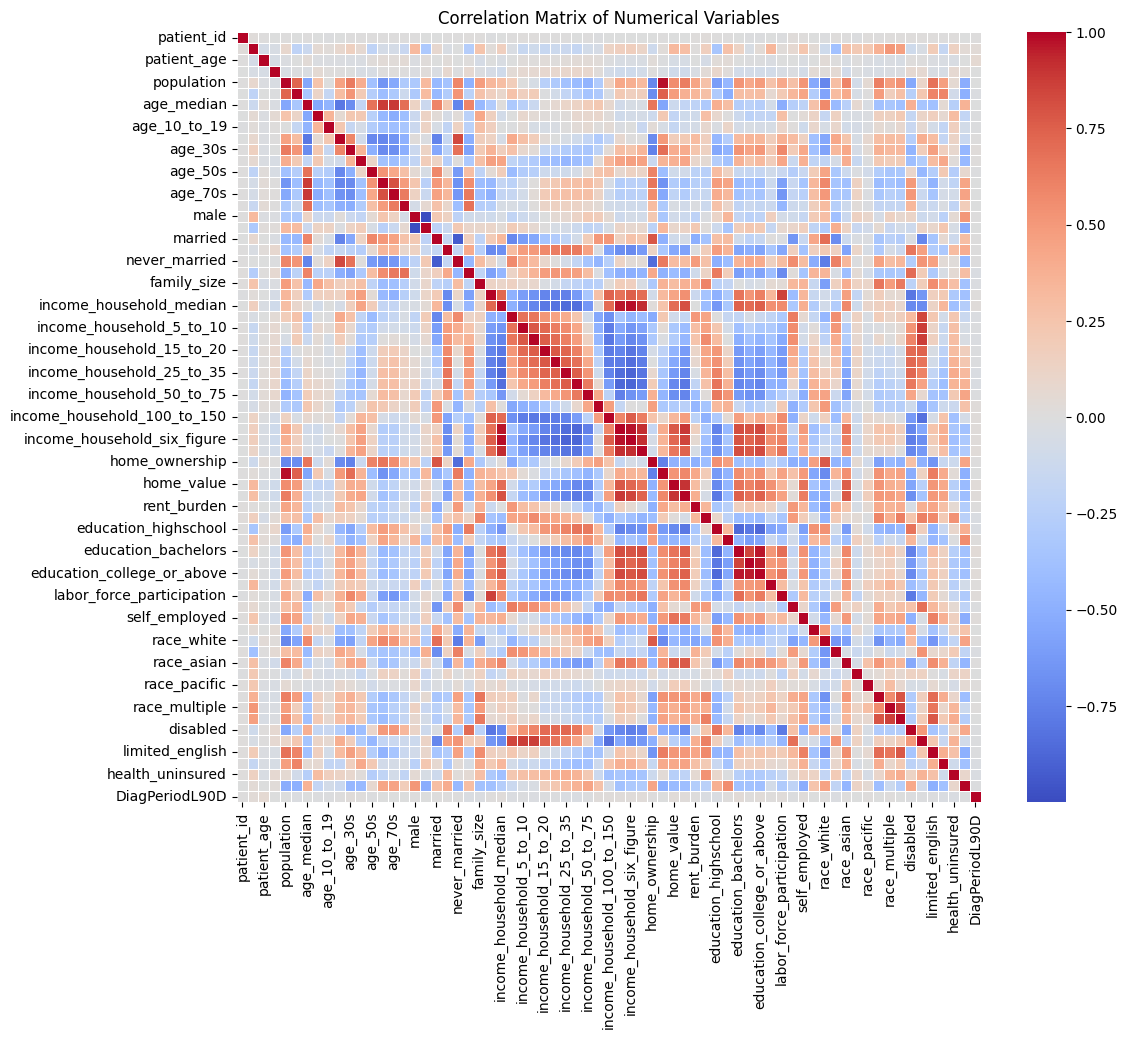

In [12]:
# Correlation Analysis
# Selecting numerical variables for correlation analysis
numerical_vars_for_corr = train_df_cleaned.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = train_df_cleaned[numerical_vars_for_corr].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title("Correlation Matrix of Numerical Variables")
plt.show()



Correlation Analysis: \
The heatmap of the correlation matrix shows high correlations between environmental factors (like Ozone, PM25, N02) and demographic factors (like density, income, education) that might indicate underlying patterns worth exploring further. 

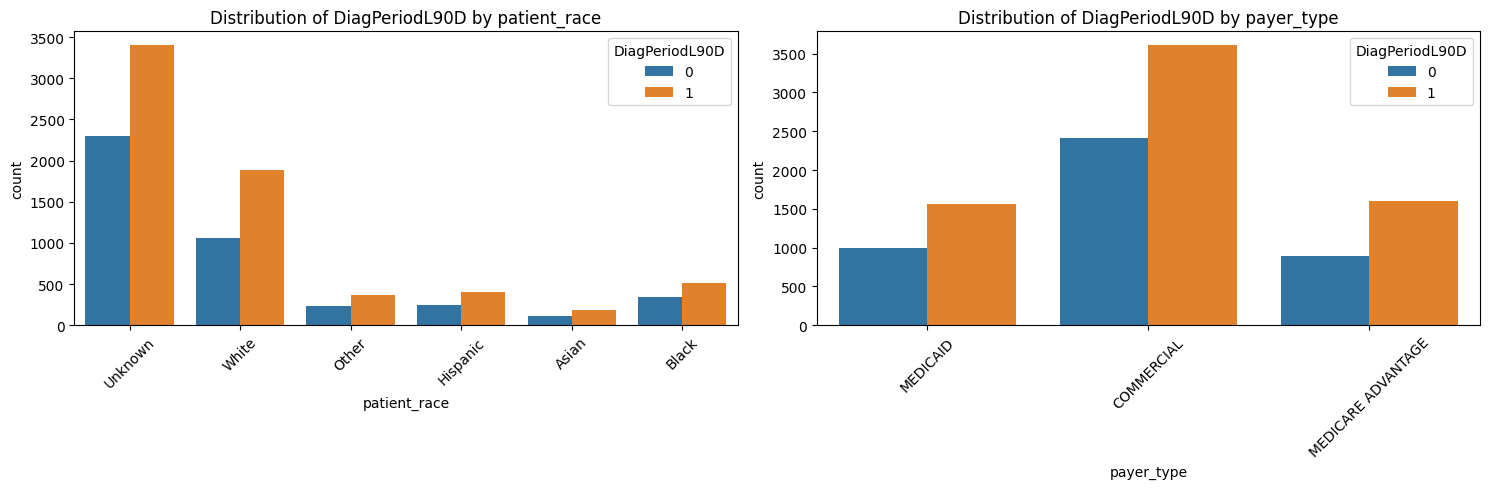

In [13]:
# Categorical Data with the Target Variable

plt.figure(figsize=(15, 5))
for i, col in enumerate(['patient_race', 'payer_type']):
    plt.subplot(1, 2, i + 1)
    sns.countplot(x=col, hue='DiagPeriodL90D', data=train_df_cleaned)
    plt.title(f'Distribution of DiagPeriodL90D by {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Figure size 2000x1000 with 0 Axes>

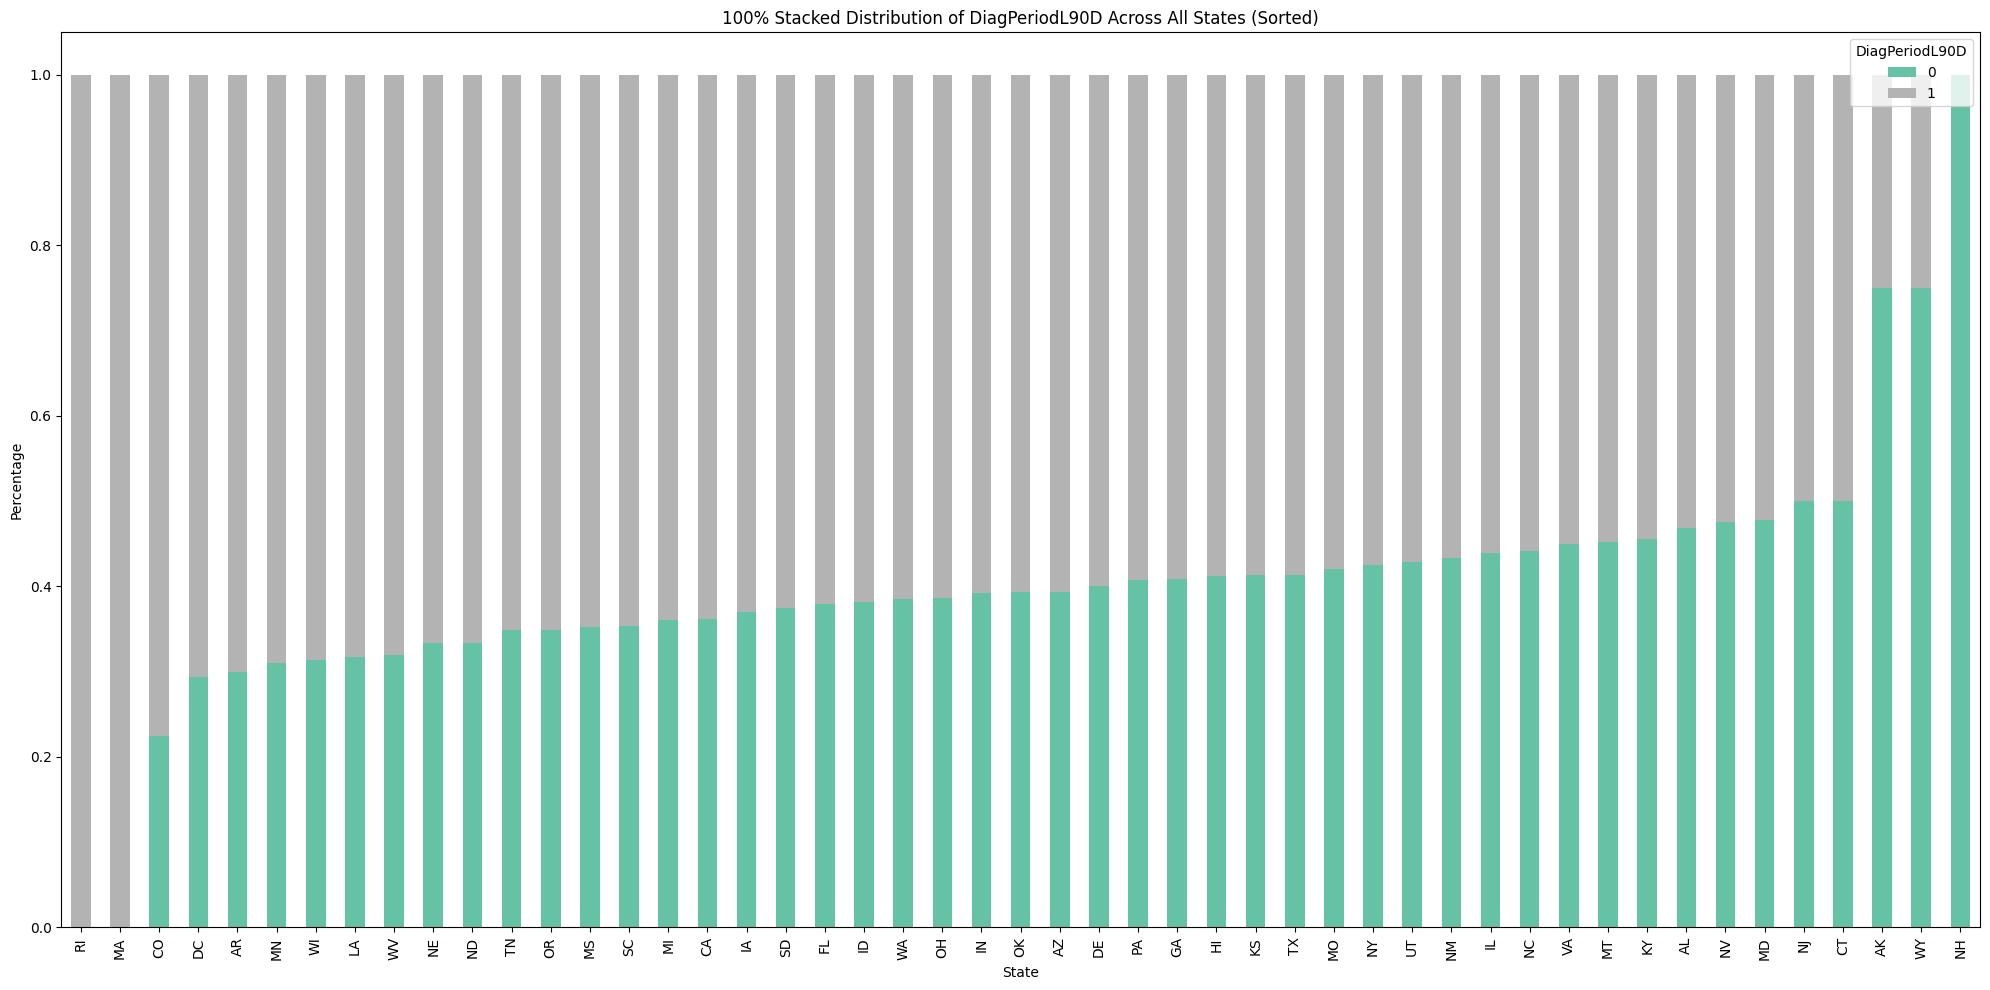

In [14]:
# Calculating the percentage of positive DiagPeriodL90D for each state
state_diagnosis_counts = train_df_cleaned.groupby(['patient_state', 'DiagPeriodL90D']).size().unstack(fill_value=0)
state_diagnosis_percentages = state_diagnosis_counts.divide(state_diagnosis_counts.sum(axis=1), axis=0)

# Sort the states by the percentage of positive diagnosis period (DiagPeriodL90D = 1)
sorted_states = state_diagnosis_percentages.sort_values(by=1, ascending=False)

plt.figure(figsize=(20, 10))
sorted_states.plot(kind='bar', stacked=True, colormap='Set2', figsize=(20, 10))
plt.title('100% Stacked Distribution of DiagPeriodL90D Across All States (Sorted)')
plt.xlabel('State')
plt.ylabel('Percentage')
plt.legend(title='DiagPeriodL90D', loc='upper right')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Most common breast cancer diagnosis codes:

In [15]:
# Most common breast cancer diagnosis codes
breast_cancer_analysis_simplified = train_df_cleaned.groupby('breast_cancer_diagnosis_code').agg(
    Frequency=('breast_cancer_diagnosis_code', 'size'),
    #Description=('breast_cancer_diagnosis_desc', 'first')
).nlargest(10, 'Frequency').reset_index()

breast_cancer_analysis_simplified


,breast_cancer_diagnosis_code,Frequency
0,1749,1761
1,C50911,1479
2,C50912,1407
3,C50919,1227
4,C50411,848
5,C50412,778
6,C50811,438
7,C50812,365
8,1744,349
9,1748,274


Most common metastatic cancer diagnosis codes:

In [16]:
# Most common metastatic cancer diagnosis codes
metastatic_cancer_diagnosis_freq = train_df_cleaned['metastatic_cancer_diagnosis_code'].value_counts()
metastatic_cancer_diagnosis_freq.head(10)


metastatic_cancer_diagnosis_code
C773     6107
C7951    1547
C779      667
C7981     403
C7800     343
C787      294
C7989     288
C799      243
C7931     230
C792      147
Name: count, dtype: int64

In [17]:
# Association of the most common breast cancer diagnosis codes with the target variable 'DiagPeriodL90D'

# Filtering the dataset for the top breast cancer diagnosis codes
top_breast_cancer_codes = breast_cancer_analysis_simplified['breast_cancer_diagnosis_code']
filtered_data = train_df_cleaned[train_df_cleaned['breast_cancer_diagnosis_code'].isin(top_breast_cancer_codes)]

# Creating a table for each code against the target variable
association_analysis = pd.crosstab(
    filtered_data['breast_cancer_diagnosis_code'], 
    filtered_data['DiagPeriodL90D']
)

# Calculating the percentage of cases diagnosed within less than 90 days for each code
association_analysis['Percentage < 90 Days'] = (
    association_analysis[1] / (association_analysis[0] + association_analysis[1]) * 100
).round(2)

association_analysis


DiagPeriodL90D,0,1,Percentage < 90 Days
breast_cancer_diagnosis_code,,,
1744,320,29,8.31
1748,249,25,9.12
1749,1610,151,8.57
C50411,186,662,78.07
C50412,167,611,78.53
C50811,75,363,82.88
C50812,78,287,78.63
C50911,330,1149,77.69
C50912,336,1071,76.12


This analysis suggests that certain types of breast cancer (as indicated by specific diagnosis codes) are associated with a faster diagnosis period. \
The reasons behind this could be varied, including the nature of the cancer type, awareness of specific symptoms, or the effectiveness of diagnostic procedures for certain types.

# Feature Enegineering and Selection

In [18]:
# Imputing missing values in 'bmi' with the median
train_df_cleaned.fillna({'bmi': train_df_cleaned['bmi'].median()}, inplace=True)
test_df_cleaned.fillna({'bmi': test_df_cleaned['bmi'].median()}, inplace=True)


In [19]:
# Applying one-hot encoding to categorical columns
cat_features = ['patient_race', 'payer_type', 'patient_state', 'Region', 'Division', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code']
train_encoded= pd.get_dummies(train_df_cleaned, columns=cat_features)
train_encoded.shape

(11065, 231)

In [20]:
test_encoded= pd.get_dummies(test_df_cleaned, columns=cat_features)
test_encoded.shape

(5792, 218)

In [21]:
X = train_encoded.drop('DiagPeriodL90D', axis=1)
y = train_encoded['DiagPeriodL90D']

In [22]:
# for column in X.columns:
#     if column not in test_encoded.columns:
#         test_encoded[column] = 'False'

# # Ensure the order of columns matches

        
# for column in test_encoded.columns:
#     if column not in X.columns:
#         X[column] = 'False'

In [23]:
X, test_encoded = X.align(test_encoded, join='outer', axis=1, fill_value=0)

In [24]:
print(X.shape)
print(test_encoded.shape)

(11065, 233)
(5792, 233)


In [25]:
test_encoded = test_encoded[X.columns]

In [26]:
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
#     ],
#     remainder='passthrough'  # This passes through other columns not specified in transformers
# )

In [27]:
# # Fit the preprocessor on the training data and transform it
# X_train_transformed = preprocessor.fit_transform(X)

# new_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(input_features=cat_features)
# all_columns = list(new_columns) + [col for col in X.columns if col not in cat_features]

# X_train_transformed = pd.DataFrame(X_train_transformed, columns=all_columns)
# X_train_transformed.shape

In [28]:
# # Transform the test data using the already fitted preprocessor
# X_test_transformed = preprocessor.transform(test_df_cleaned)
# X_test_transformed = pd.DataFrame(X_test_transformed, columns=all_columns)

# X_test_transformed.shape

In [29]:
#X_test_transformed = X_test_transformed[X_train_transformed.columns]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### PCA

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

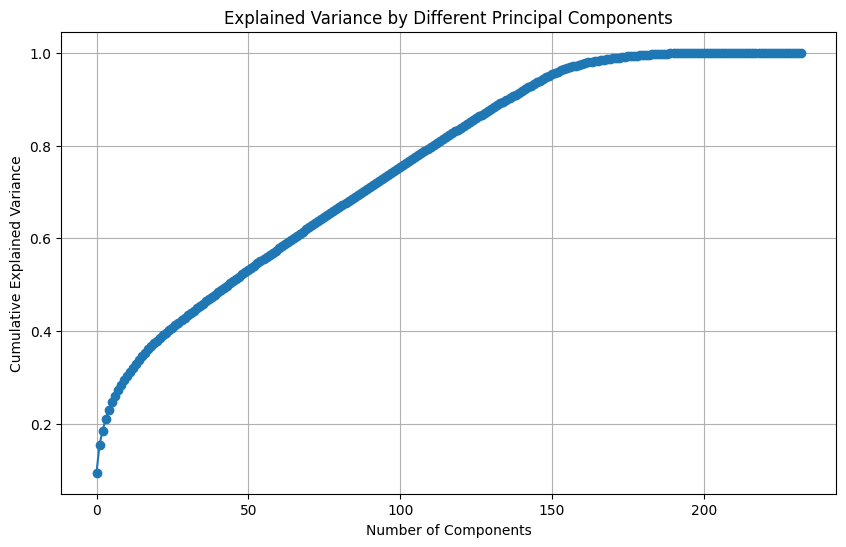

In [32]:
# Applying PCA without reducing the dimensions
pca_full = PCA()
pca_full.fit(X_scaled)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(10,6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Different Principal Components')
plt.grid()
plt.show()

In [33]:
#Selecting 160 components based on chart. 
pca = PCA(n_components=160)
X_pca = pca.fit_transform(X_scaled)

# Random Forest Classifier

In [34]:
# On complete data
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
print(f"ROC AUC Score: {roc_auc}")

              precision    recall  f1-score   support

           0       0.76      0.61      0.67      1251
           1       0.79      0.88      0.83      2069

    accuracy                           0.78      3320
   macro avg       0.77      0.74      0.75      3320
weighted avg       0.78      0.78      0.77      3320

ROC AUC Score: 0.7823931285131392


In [35]:
# On data after PCA
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
print(f"ROC AUC Score: {roc_auc}")

              precision    recall  f1-score   support

           0       0.80      0.59      0.68      1251
           1       0.79      0.91      0.84      2069

    accuracy                           0.79      3320
   macro avg       0.79      0.75      0.76      3320
weighted avg       0.79      0.79      0.78      3320

ROC AUC Score: 0.794583472902683


### Hyperparameter tuning with GridSearch

In [36]:
# from sklearn.model_selection import GridSearchCV

# X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# rf = RandomForestClassifier(random_state=42)

# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=2, n_jobs=-1)

# grid_search.fit(X_train, y_train)

# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)



In [37]:
# best_rf_model = RandomForestClassifier(random_state=42)
# y_pred = best_rf_model.predict(X_test)
# y_prob = best_rf_model.predict_proba(X_test)[:, 1]
# roc_auc = roc_auc_score(y_test, y_prob)

# print(classification_report(y_test, y_pred))
# print(f"ROC AUC Score: {roc_auc}")

# XGBoost Classifier

In [38]:
# On full dimensional data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = xgb.XGBClassifier(use_label_encoder=False, objective ='binary:logistic', eval_metric='auc')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

y_prob = model.predict_proba(X_test)[:, 1]  
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_auc)

              precision    recall  f1-score   support

           0       0.80      0.62      0.70      1251
           1       0.80      0.90      0.85      2069

    accuracy                           0.80      3320
   macro avg       0.80      0.76      0.77      3320
weighted avg       0.80      0.80      0.79      3320

ROC AUC Score: 0.7994783486888594


In [39]:
# On data after PCA 
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

y_prob = model.predict_proba(X_test)[:, 1]  
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_auc)

              precision    recall  f1-score   support

           0       0.74      0.60      0.66      1251
           1       0.78      0.87      0.83      2069

    accuracy                           0.77      3320
   macro avg       0.76      0.74      0.75      3320
weighted avg       0.77      0.77      0.77      3320

ROC AUC Score: 0.785105313525883


### Hyperparameter tuning with GridSearch

In [40]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [100, 200, 300],
#     'subsample': [0.8, 0.9, 1.0]
# }

# model = xgb.XGBClassifier(use_label_encoder=False, objective ='binary:logistic', eval_metric='auc')

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring="roc_auc", verbose=1)

# grid_search.fit(X_train, y_train)

# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model_optimized = xgb.XGBClassifier(
    learning_rate=0.1,
    max_depth=4,
    n_estimators=100,
    subsample=0.9,
    use_label_encoder=False,
    eval_metric='auc'
)

model_optimized.fit(X_train, y_train)

y_pred = model_optimized.predict(X_test)
print(classification_report(y_test, y_pred))

y_prob = model_optimized.predict_proba(X_test)[:, 1] 
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_auc)

              precision    recall  f1-score   support

           0       0.89      0.59      0.71      1251
           1       0.79      0.96      0.87      2069

    accuracy                           0.82      3320
   macro avg       0.84      0.77      0.79      3320
weighted avg       0.83      0.82      0.81      3320

ROC AUC Score: 0.8129214366544464


# Applying final model to test data

In [42]:
X_new = test_encoded


In [43]:
#Using already trained optimized XGBoost model

#predict probabilities for the test data
test_probabilities = model_optimized.predict_proba(X_new)[:, 1]

# Creating the submission DataFrame
results_df = pd.DataFrame({
    'patient_id': X_new['patient_id'],
    'DiagPeriodL90D': test_probabilities
})

results_df['patient_id'] = results_df['patient_id'].astype(int)

print(results_df.head())

results_df.to_csv('submission.csv', index=False)


   patient_id  DiagPeriodL90D
0      573710        0.807660
1      593679        0.712826
2      184532        0.750664
3      447383        0.780019
4      687972        0.758761


In [44]:
results_df.shape

(5792, 2)

In [45]:
# Getting feature importances from the trained model
feature_importance = model_optimized.feature_importances_

# Creating a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance
})

# Sorting the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)


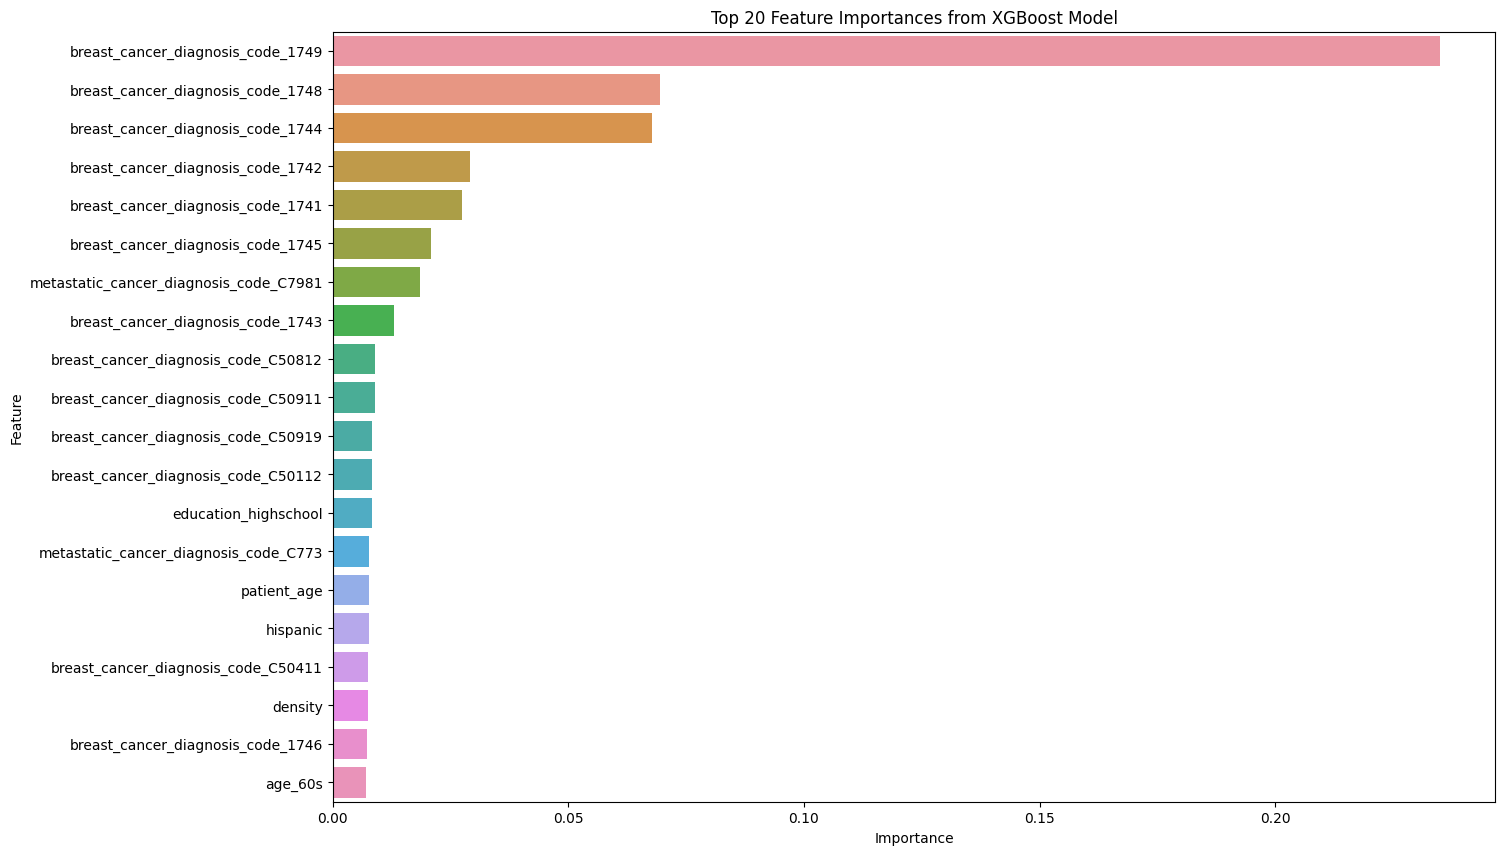

In [46]:
plt.figure(figsize=(15, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances from XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

**Final Model Evaluation:**

* Model: XGBoost Classifier with optimized parameters.
* Learning Rate: 0.1
* Max Depth: 4
* Number of Estimators: 100
* Subsample: 0.9

**Feature Importance**
Feature importance analysis for the final XGBoost model highlighted the top features influencing the prediction:

The top 20 features were visualized, providing insights into which variables were most impactful. This included features related to patient demographics, geographic location, and insurance type.

In [47]:
# Applying Final Model to Test Data
X_new = test_encoded
test_probabilities = model_optimized.predict_proba(X_new)[:, 1]

results_df = pd.DataFrame({
    'patient_id': X_new['patient_id'],
    'DiagPeriodL90D': test_probabilities
})
results_df['patient_id'] = results_df['patient_id'].astype(int)
results_df.to_csv('submission.csv', index=False)

# Conclusion
The project successfully developed a predictive model to identify the likelihood of timely metastatic cancer diagnosis based on demographic and socio-economic factors. The XGBoost classifier, with optimized hyperparameters, demonstrated strong predictive performance. Feature importance analysis provided valuable insights into the key factors driving diagnosis timeliness, supporting further investigation and potential policy implications to improve health equity in cancer diagnosis.